In [1]:
import numpy as np
import pandas as pd
import sklearn.linear_model as lm

import mlgrad.model as model
import mlgrad.func as func
import mlgrad.loss as loss
import mlgrad.avragg as avragg
import mlgrad.gd as gd
import mlgrad.pbfg as pbfg

import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper', 'seaborn-white'])
plt.matplotlib.rcParams['figure.dpi']=100
plt.matplotlib.rcParams['savefig.dpi']=100


In [2]:
X_r = np.random.random(400)
Y_r = np.random.random(400)
X_r = 3 * X_r
Y_r = 3 * Y_r ** 3.0
X0 = np.linspace(0.0, 3.0, 100)
Y0 = 0.9 * X0

X = np.concatenate((X_r, X0))
Y = np.concatenate((Y_r, Y0))
Xv = X.reshape(-1,1)


In [3]:
loss_func = loss.Loss(func.Square())
loss_func

In [4]:
penalty_func = func.Quantile_AlphaLog(0.01, 0.21)
penalty_func

In [10]:
param_init = np.array([3.,1.])
lm_learn = model.LinearModel(param_init)

avrfunc = avragg.Average_FG(penalty_func, h=0.05, tol=1.0e-5)
avrfunc.use_deriv_averager(avragg.AdaM1())
fg = gd.FG(lm_learn, loss_func, h=0.0008, tol=1.0e-5)
fg.use_gradient_averager(gd.AdaM1())

d = {"u":[],"param":[], "K":[], "Ka":[], "lmin":[]}
def callback(alg):
    d["u"].append(avrfunc.u)
    d["K"].append(fg.K)
    d["lmin"].append(fg.lval_min)
    d["Ka"].append(avrfunc.K)
    d["param"].append(lm_learn.param.base.copy())

alg = pbfg.PbFG(avrfunc, fg, tol=1.0e-5)
alg.callback = callback
alg.fit(Xv, Y)
print("K:", alg.K, "Kgd:", fg.K, "Ka:", avrfunc.K, lm_learn.param.base)

K: 29 Kgd: 2 Ka: 21 [-0.04557193  0.9154997 ]


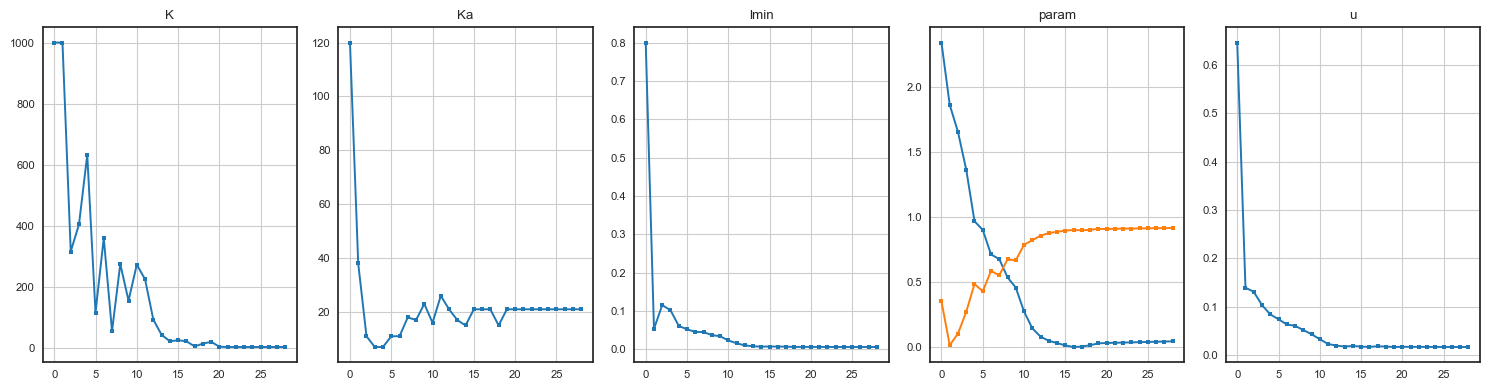

In [11]:
def plot_log(d):
    plt.figure(figsize=(15,4))
    m = len(d)
    i = 1
    for key, vals in sorted(d.items()):
        plt.subplot(1, m, i)
        k_range, u_seq = zip(*enumerate(d[key]))
        plt.plot(k_range, np.abs(u_seq), marker='s', markersize=3)
        plt.grid(1)
        plt.title(key)
        plt.minorticks_on()
        i += 1
        plt.tight_layout()
    plt.show()
    
plot_log(d)

In [7]:
# param_init2 = np.random.random((2,))
# lm_learn2 = model.LinearModel(param_init2)
# print(np.array(lm_learn2.param))

# alg2 = sag.SAG(lm_learn2, func.Quantile(0.25), h=0.01, tol=1.0e-4, n_iter=10000)
# alg2.fit(Xv, Y)
# print("K:", alg2.K, "h:", alg2.h, "param:", np.array(lm_learn2.param))

In [8]:
ransac = lm.RANSACRegressor(loss='squared_loss')
ransac.fit(Xv, Y)
lsm = lm.LinearRegression()
lsm.fit(Xv, Y)
theil = lm.TheilSenRegressor()
theil.fit(Xv, Y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)

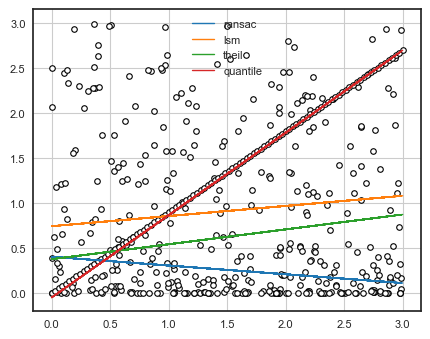

In [9]:
plt.figure(figsize=(5,4))
plt.scatter(X, Y, s=16, c='w', edgecolors='k', linewidth=0.8)
plt.plot(X, ransac.predict(Xv), label='ransac', linewidth=1.0)
plt.plot(X, lsm.predict(Xv), label='lsm', linewidth=1.0)
plt.plot(X, theil.predict(Xv), label='theil', linewidth=1.0)
plt.plot(X, lm_learn.evaluate_all(Xv), label='quantile', linewidth=1.0)
#plt.plot(X, [lm_learn2.evaluate(x) for x in Xv], label='quantile_sag', linewidth=3.0)
plt.grid(1)
plt.minorticks_on()
plt.legend(loc='best')
plt.show()